# One Pixel Attack
## Cifar10

### Franco Pinto, 1592439
### Floris Ciprian Dinu, 1593921
### 20 September, 2018

![](images/pred2.png "All it takes is one pixel")

This notebook will demonstrate the one pixel attack with two different neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.


## Imports

In [2]:
# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from keras import backend as K

# Import Networks
from networks.lenet import LeNet
from networks.resnet import ResNet


# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

## Load Dataset

For this attack, we will use the Cifar10 dataset packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can access and display any image in the dataset by its index. For instance, here is a horse.

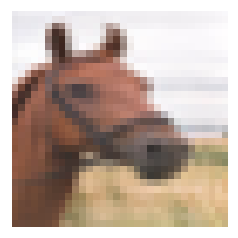

In [19]:
image = 99 # Image index in the test set
helper.plot_image(x_test[image])

## Image Perturbation

To begin, we need a function to modify one or more pixels in an image. 

We can define the perturbation of a pixel as a 5-tuple 

$$\textbf{x} = (x, y, r, g, b)$$

where $x, y$ are the coordinates of the pixel from 0 to 31, and $r,g,b$ are the red, green, and blue values from 0 to 255. 

Then the function to perturb an image can take as an input the image and $X$, and output a copy of the image with each pixel at $x_i, y_i$ modified to have the color $r_i, g_i, b_i$. 

In [6]:
def perturb_image(xs, img):
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

Now we can modify the pixels of any image we want.

Let's modify our horse image by making pixel (16,16) yellow.

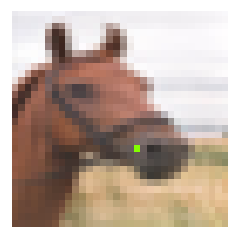

In [20]:
image = 99 # Image index in the test set
pixel = np.array([20, 18, 132, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image])[0]

helper.plot_image(image_perturbed)


## Load Models

To demonstrate the attack, we need some neural network models trained on the Cifar10 dataset. We will now load some pretrained models, which can be found in the `networks/models` directory.

There are two models included in this repository, `lenet` and `resnet` which will be loaded from disk automatically.

In [9]:
lenet = LeNet()
resnet = ResNet()

models = [lenet, resnet]

Successfully loaded lenet
Successfully loaded resnet


### Calculate Model Accuracies

After loading the models, we would like to evaluate all test images with each model to ensure that we only attack the images which have been classified correctly. The code below will also display the accuracy and number of parameters of each model.

In [24]:
# Lenet
#we first select the images that have been correctly classified. 
correct_imgs_lenet = helper.evaluate_models([lenet], x_test, y_test)
correct_imgs_lenet = pd.DataFrame(correct_imgs_lenet, columns=['name', 'img', 'label', 'confidence', 'pred'])

#then we select the images that have been wrongly classified.
wrong_imgs_lenet = helper.wrongimg([lenet], x_test, y_test)

# correct_imgs_lenet
# wrong_img_lenet

Evaluating lenet
Evaluating lenet


,name,img,label,confidence,pred
0,lenet,0,3,0.845718,"[0.000266958, 0.00414062, 0.00860135, 0.845718..."
1,lenet,1,8,0.897515,"[0.0306152, 0.0516909, 0.000123243, 2.29141e-0..."
2,lenet,2,8,0.883613,"[0.0104792, 0.0822038, 0.000511889, 0.00142718..."
3,lenet,3,0,0.869531,"[0.869531, 0.00834104, 0.01472, 0.00101565, 0...."
4,lenet,4,6,0.995537,"[1.13859e-08, 1.09058e-08, 0.00216072, 0.00010..."
5,lenet,5,6,0.996236,"[1.1625e-07, 1.74235e-06, 0.000252265, 0.00055..."
6,lenet,6,1,0.993709,"[0.000167215, 0.993709, 0.000257847, 0.0005744..."
7,lenet,7,6,0.904880,"[0.00101984, 0.000326674, 0.0842279, 0.0008128..."
8,lenet,8,3,0.461697,"[0.000203215, 5.78128e-05, 0.07643, 0.461697, ..."
9,lenet,9,1,0.770601,"[0.00639549, 0.770601, 0.000119752, 0.00030886..."


In [23]:
#Resnet
#we first select the images that have been correctly classified. 
correct_imgs_resnet = helper.evaluate_models([resnet], x_test, y_test)
correct_imgs_resnet = pd.DataFrame(correct_imgs_resnet, columns=['name', 'img', 'label', 'confidence', 'pred'])

#then we select the images that have been wrongly classified.
wrong_imgs_resnet = helper.wrongimg([resnet], x_test, y_test)

# correct_imgs_resnet
# wrong_img_resnet

Evaluating resnet


KeyboardInterrupt: 

Here we show the average confidence for the `lenet` network predictions.

In [12]:
sum(correct_imgs_lenet.confidence)/7488 # 7488 is the number of correctly classified images
avg_confidence_lenet = 0
for c in correct_imgs_lenet.confidence: 
    avg_confidence_lenet += c
    
avg_confidence_lenet/len(correct_imgs_lenet.confidence)

0.8575203725033336

Here we show the average confidence for the `resnet` network predictions.

In [44]:
sum(correct_imgs_resnet.confidence)/9231 # 9231 is the number of correctly classified images
avg_confidence_resnet = 0
for c in correct_imgs_resnet.confidence: 
    avg_confidence_resnet += c
    
avg_confidence_resnet/len(correct_imgs_resnet.confidence)

0.9865690064790538

For `resnet`, in the following cell we are plotting the average confidence for each 200 predictions in red. We can observe that, as stated above, the confidence is very high (near to 0.99). In blue we are plottin the values of each 10 wrong predictions.

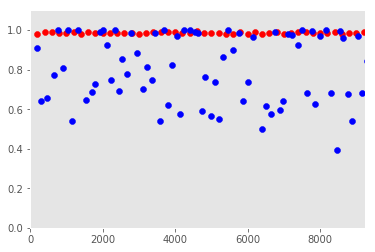

In [45]:
plt.axis([0, 9231, 0, 1.1])
plt.grid()

counter = 1
total_confidence = 0
color = 'r'

for c in correct_imgs_resnet.confidence: 
    
    total_confidence = total_confidence + c
    
    if counter%200 == 0:
        total_confidence = total_confidence / 200
        point = [counter, total_confidence]
        plt.scatter(point[0], point[1], c=color)
        total_confidence = 0
        counter = counter +1
    else:
        counter = counter +1

counter = 1
total_confidence = 0
color = 'b'  
        
for p in wrong_imgs_resnet: # p is the array containing data about a prediction, as label or confidence
    
    total_confidence = total_confidence + p[3]
    
    if counter%10 == 0:
        total_confidence = total_confidence / 10
        point = [p[1], p[3]] # p[1] is image number, p[3] is the prediction
        plt.scatter(point[0], point[1], c=color)
        total_confidence = 0
        counter = counter +1
    else:
        counter = counter +1 

For `lenet`, in the following cell we are plotting the average confidence for each 200 predictions in blue. We can observe that, as stated above, the confidence is pretty high (near to 0.86). In blue we are plottin the values of each 30 wrong predictions.

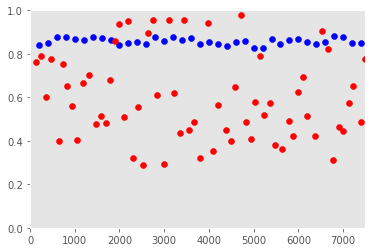

In [13]:
plt.axis([0, 7488, 0, 1])
plt.grid()

counter = 1
total_confidence = 0
color = 'b'

for c in correct_imgs_lenet.confidence: 
    
    total_confidence = total_confidence + c
    
    if counter%200 == 0:
        total_confidence = total_confidence / 200
        point = [counter, total_confidence]
        plt.scatter(point[0], point[1], c=color)
        total_confidence = 0
        counter = counter +1
    else:
        counter = counter +1

counter = 1
total_confidence = 0
color = 'r'  
        
for p in wrong_imgs_lenet:
    
    total_confidence = total_confidence + p[3]
    
    if counter%30 == 0:
        total_confidence = total_confidence / 30
        point = [p[1], p[3]]
        plt.scatter(point[0], point[1], c=color)
        total_confidence = 0
        counter = counter +1
    else:
        counter = counter +1      

### Prediction Function

For the black-box attack, all we should care about is the inputs to the model (the images), and the outputs of the model (the prediction probabilities).

Define a function that runs several perturbed images on a given model and returns the model's confidence (probability output) in the target class, one confidence value per image. If the target class is the correct class, this will be the function that we want to minimize so that the model will be most confident in another class (which is incorrect). Otherwise, the target is an incorrect class and we will want to maximize it.

Below we can modify a pixel in an image and see how the confidence of the model changes. In almost all cases, the confidence will not change. However, for very special cases it will change drastically.

Confidence in true class bird is 0.0350836
Prior confidence was 0.036496


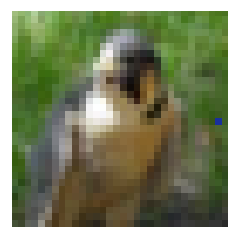

In [14]:
image = 384
pixel = np.array([16, 30,  25, 48, 156])
model = lenet

true_class = y_test[image,0]
prior_confidence = model.predict_one(x_test[image])[true_class]  
confidence = model.predict_one(perturb_image(pixel, x_test[image]))[true_class]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, x_test[image])[0])

## The Attack

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to perturb an image as to minimize the confidence probability of the correct classification category and maximize the sum of the probabilities of all other categories.

### Success Criterion

Define a function so that whenever a given perturbation is sufficient to fool a model, it returns `True`. This will be called the success criterion. 

In [15]:
def attack_success(x, img, target_class, model):
    # Perturb the image with the given pixel and get the prediction of the model
    perturbed_image = perturb_image(x, x_test[img])

    confidence = model.predict(perturbed_image)[0] # returns all the probabilities

    predicted_class = np.argmax(confidence) # the index of the class in class_names

    # If the prediction is what we want, return True

    print('Confidence:', confidence[target_class])
    if (predicted_class != target_class):
        return True # if true, attack successfull

Here we demonstrate the usage of the success criterion function. It's nearly identical to `predict_class()` as before, but also decides the success of the attack. 

Confidence: 0.182876
Prior confidence 0.105319
Attack success: True


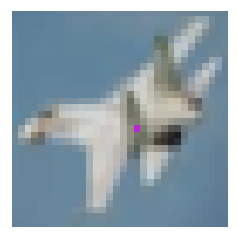

In [16]:
image = 10 
pixel = np.array([17, 18, 185, 36, 215])
model = lenet

true_class = y_test[image,0]
prior_confidence = model.predict_one(x_test[image])[true_class]
success = attack_success(pixel, image, true_class, model)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)

helper.plot_image(perturb_image(pixel, x_test[image])[0])

### Attack Function

In [17]:
def attack(img, model, 
           maxiter=125, popsize=400):
    
    target_class =  y_test[img,0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)]
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    predict_fn = lambda xs: model.predict(
        perturb_image(xs, x_test[img]))[0]
    callback_fn = lambda x, convergence: attack_success(
        x, img, target_class, model)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img])[0]
    prior_probs = model.predict_one(x_test[img])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img,0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, img, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

#### Untargeted Attack

Let's look at one iteration of the untargeted attack. Here we will demonstrate a successful attack an image of a ship with the `lenet` model. We should see the confidence in the true class drop after several iterations.


Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.731417
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.672413
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0.641947
Confidence: 0

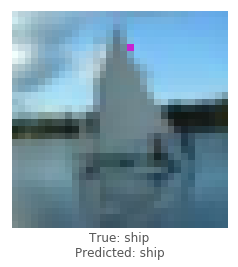

In [18]:
image = 9963
model = lenet

_ = attack(image, model)

Lets look at one iteration of the untargeted attack. Here we will demonstrate a successful attack an image of a frog with the `resnet` model. We should see the confidence in the true class drop after several iterations.

In [78]:
image = 102
model = resnet

_ = attack(image, model)

Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confiden

KeyboardInterrupt: 

### Conclusion

It appears that the accuracy of a model is not strongly correlated with the chance of performing a successful attack on an image. 


